#Importing Libraries

In [ ]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import models,datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import uuid

#Configuaring Variables

In [ ]:
NUM_EPOCHS = 20
NOISE_DIMENSION = 10
BATCH_SIZE = 128
UNIQUE_RUN_ID = str(uuid.uuid4())
PRINT_STATS_AFTER_BATCH = 128
OPTIMIZER_LR = 0.0002
OPTIMIZER_BETAS = (0.5, 0.999)

In [ ]:
# For Speeding up the training
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

#DCGan Generator 

In [ ]:
class Generator(nn.Module):

  def __init__(self,):
    super().__init__()
    num_feature_maps = 64
    self.layers = nn.Sequential(
      nn.ConvTranspose2d(NOISE_DIMENSION, num_feature_maps * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(num_feature_maps * 8),
      nn.ReLU(),
      nn.ConvTranspose2d(num_feature_maps * 8, num_feature_maps * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps * 4),
      nn.ReLU(),
      nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps * 2),
      nn.ReLU(),
      nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps),
      nn.ReLU(),
      nn.ConvTranspose2d(num_feature_maps, 1, 1, 1, 2, bias=False),
      nn.Tanh()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)

In [ ]:
gen = Generator()
print(gen)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


#Fine Tuned the vgg-16 model - DC GAN Discriminator

In [ ]:
vgg_discriminator = models.vgg16(pretrained=True)
for param in vgg_discriminator.parameters():
    param.requires_grad = True

In [ ]:
vgg_discriminator.features =vgg_discriminator.features[:19]
vgg_discriminator = torch.nn.Sequential(*(list(vgg_discriminator.children())[:-1]))
print(vgg_discriminator)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Function to convert the device to GPU if available

In [ ]:
def get_device():
  return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Function for creating directory for storing the weights and images

In [ ]:
def make_directory():

  print(f'Configuring the required directories: {UNIQUE_RUN_ID}')
  if not os.path.exists('./runs'):
    os.mkdir('./runs')
  os.mkdir(f'./runs/{UNIQUE_RUN_ID}')

Function for uniform random noise generation

In [ ]:
def noise_generation(number_of_images = 1, noise_dimension = NOISE_DIMENSION, device=None):
  return torch.randn(number_of_images, noise_dimension, 1, 1, device=device)

Checking the shape of noise

In [ ]:
device=get_device()
noise = noise_generation(BATCH_SIZE, device=device)
print("Shape of noise generated:", noise.shape)
print(noise[0])


Shape of noise generated: torch.Size([128, 10, 1, 1])
tensor([[[ 0.6729]],

        [[-0.3722]],

        [[ 1.2715]],

        [[-0.4943]],

        [[-0.6871]],

        [[-0.0642]],

        [[-0.5404]],

        [[ 1.8117]],

        [[-0.7088]],

        [[ 0.3087]]], device='cuda:0')


#Function for generating images

In [ ]:
def sample_image_generation(generator, epoch = 0, batch = 0, device=get_device()):
  images = []
  noise = noise_generation(BATCH_SIZE, device=device)
  generator.eval()
  images = generator(noise)
  plt.figure(figsize=(10, 10))

  for i in range(16):
    image = images[i]

    # Convert image back onto CPU and reshape
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    
    # Plot
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  if not os.path.exists(f'./runs/{UNIQUE_RUN_ID}/images'):
    os.mkdir(f'./runs/{UNIQUE_RUN_ID}/images')
  plt.savefig(f'./runs/{UNIQUE_RUN_ID}/images/epoch{epoch}_batch{batch}.jpg')

#Dataset preparation through Dataloader

In [ ]:
def prepare_dataset():
  dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]))
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
  return trainloader

Normal weight initialization as suggested for DCGANs 

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
def efficient_zero_grad(model):
  for param in model.parameters():
    param.grad = None

Performing Forward and Backward pass

In [ ]:
def forward_and_backward(model, data, loss_function, targets):
  outputs = model(data)
  error = loss_function(outputs, targets)
  error.backward()
  return error.item()

For each batch of an epoch, performing the training step

In [ ]:
def perform_train_step(generator, discriminator, real_data, \
  loss_function, generator_optimizer, discriminator_optimizer, device = get_device()):

  # Setting  real and fake labels.

  real_label, fake_label = 1.0, 0.0
  real_images = real_data[0].to(device)
  actual_batch_size = real_images.size(0)
  label = torch.full((actual_batch_size,1), real_label, device=device)
  
  #Trainning the discriminator
  efficient_zero_grad(discriminator)
  error_real_images = forward_and_backward(discriminator, real_images, \
    loss_function, label)

  noise = noise_generation(actual_batch_size, device=device)
  generated_images = generator(noise)
  label.fill_(fake_label)
  error_generated_images =forward_and_backward(discriminator, \
    generated_images.detach(), loss_function, label)
  discriminator_optimizer.step()
  
  #Trainning the generator
  efficient_zero_grad(generator)
  label.fill_(real_label)
  error_generator = forward_and_backward(discriminator, generated_images, loss_function, label)
  generator_optimizer.step()
  
  #Results
  error_discriminator = error_real_images + error_generated_images
  return error_generator, error_discriminator

#Training the DC GAN

In [ ]:
def train():
  make_directory()
  # Set fixed random number seed
  torch.manual_seed(42)
  device = get_device()

  # Dataset preparation
  dataloader = prepare_dataset()

  # Initialize generator and discriminator for DCGAN
  generator = Generator()
  #Using VGG16 as the descriminator for the DC-GAN
  discriminator = vgg_discriminator

  # Perform proper weight initialization
  generator.apply(weights_init)
  discriminator.apply(weights_init)

  # Move models to specific device
  generator.to(device)
  discriminator.to(device)

  # Initialize loss and optimizers
  loss_function = nn.BCELoss()
  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)

  # Train the model
  gloss=[]
  dloss=[]
  for epoch in range(NUM_EPOCHS):
    print(f'Starting epoch {epoch}...')
    g=[]
    d=[]

    """ Perform a single epoch. """
    for batch_no, real_data in enumerate(dataloader, 0):
      # Perform training step
      generator_loss_val, discriminator_loss_val = perform_train_step(generator, \
        discriminator, real_data, loss_function, \
        generator_optimizer, discriminator_optimizer)
      g.append(generator_loss_val)
      d.append(discriminator_loss_val)
      
      if batch_no % PRINT_STATS_AFTER_BATCH == 0:
        print('Losses after mini-batch %5d: generator %e, discriminator %e' %(batch_no, generator_loss_val, discriminator_loss_val))
        if(batch_no in [0,384]):
          sample_image_generation(generator, epoch, batch_no)
    
    gloss.append(g)
    dloss.append(d)
    torch.cuda.empty_cache()

  print('Finish Training')
  return gloss,dloss

Preparing training run c7eea21f-1db9-4109-8f1f-f22e63c6e447


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Starting epoch 0...
Losses after mini-batch     0: generator 6.333706e-01, discriminator 1.390375e+00
Losses after mini-batch   128: generator 2.448368e+00, discriminator 1.543155e-01
Losses after mini-batch   256: generator 3.938177e+00, discriminator 3.306068e-02
Losses after mini-batch   384: generator 2.267752e+00, discriminator 6.722911e-01
Starting epoch 1...
Losses after mini-batch     0: generator 1.355948e+00, discriminator 9.901829e-01
Losses after mini-batch   128: generator 1.680324e+00, discriminator 6.264621e-01
Losses after mini-batch   256: generator 1.568204e+00, discriminator 6.767664e-01
Losses after mini-batch   384: generator 1.379035e+00, discriminator 9.928793e-01
Starting epoch 2...
Losses after mini-batch     0: generator 3.027319e+00, discriminator 9.033051e-01
Losses after mini-batch   128: generator 2.130397e+00, discriminator 8.801467e-01
Losses after mini-batch   256: generator 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Losses after mini-batch   128: generator 9.349978e-01, discriminator 1.094701e+00
Losses after mini-batch   256: generator 9.247921e-01, discriminator 9.663491e-01
Losses after mini-batch   384: generator 1.046080e+00, discriminator 9.808800e-01
Starting epoch 11...
Losses after mini-batch     0: generator 1.049878e+00, discriminator 1.028084e+00
Losses after mini-batch   128: generator 5.324309e-01, discriminator 1.368649e+00
Losses after mini-batch   256: generator 2.144404e+00, discriminator 1.024710e+00
Losses after mini-batch   384: generator 1.463597e+00, discriminator 1.099669e+00
Starting epoch 12...
Losses after mini-batch     0: generator 1.308686e+00, discriminator 8.258516e-01
Losses after mini-batch   128: generator 1.391682e+00, discriminator 8.721165e-01
Losses after mini-batch   256: generator 8.249045e-01, discriminator 1.216291e+00
Losses after mini-batch   384: generator 1.743723e+00, discriminator 1.070091e+00
Starting epoch 13...
Losses after mini-batch     0: gene

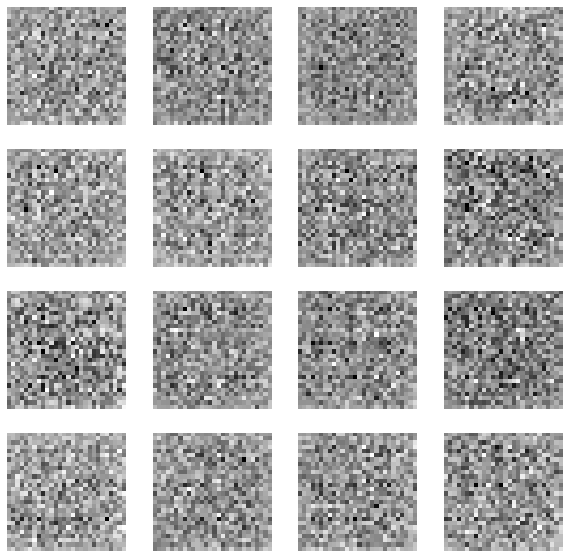

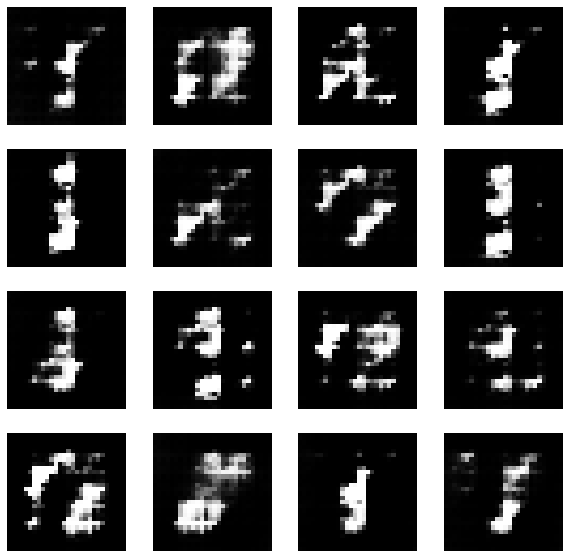

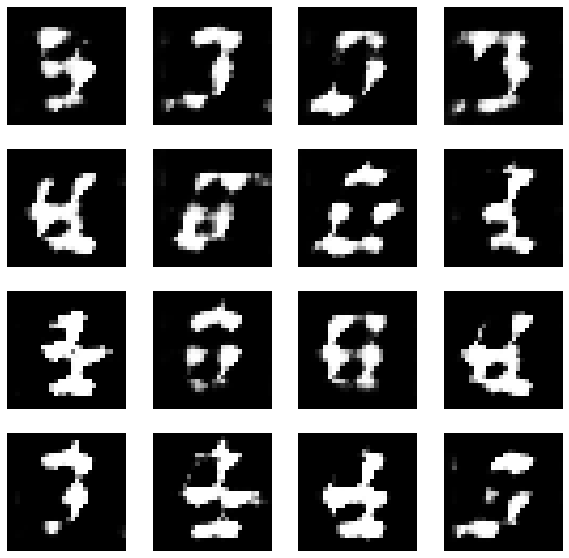

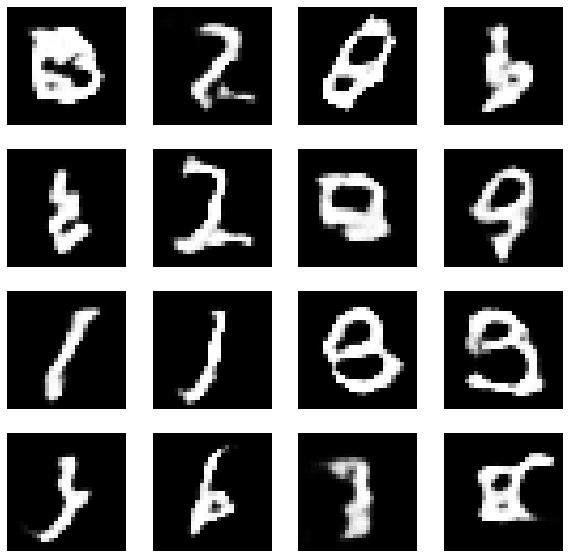

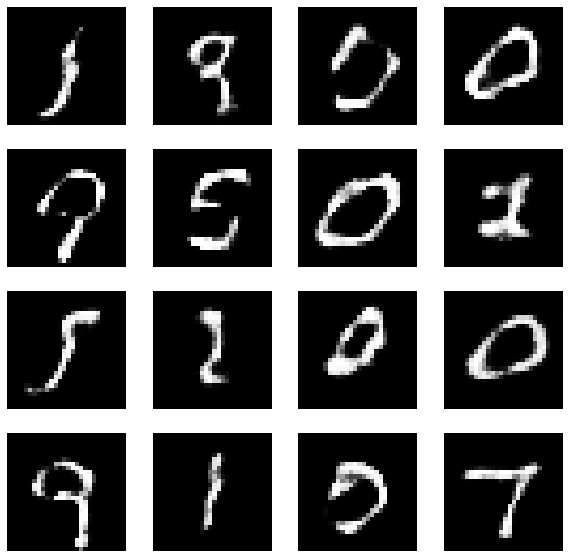

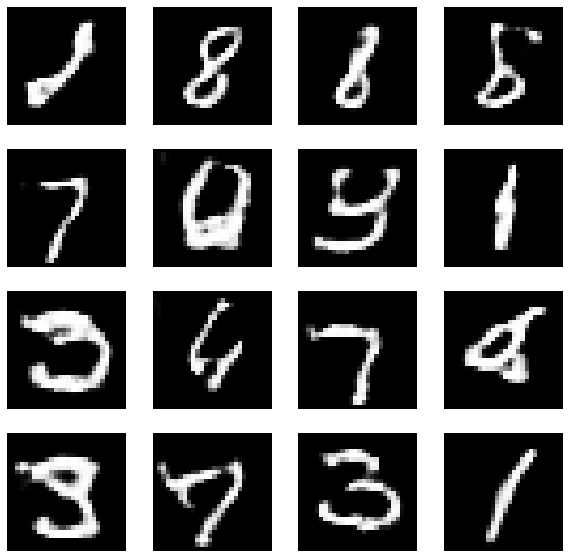

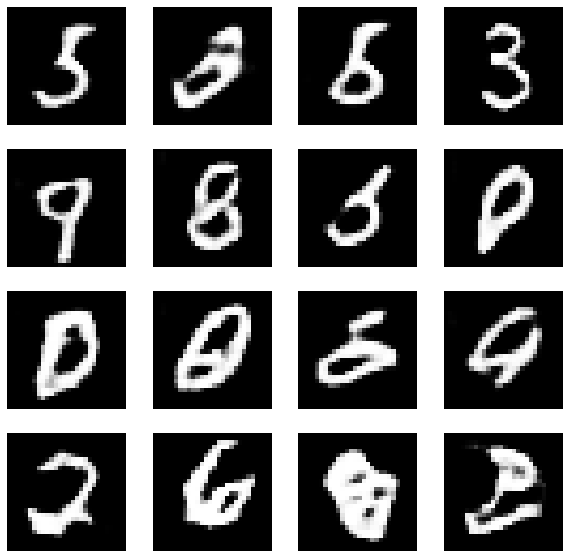

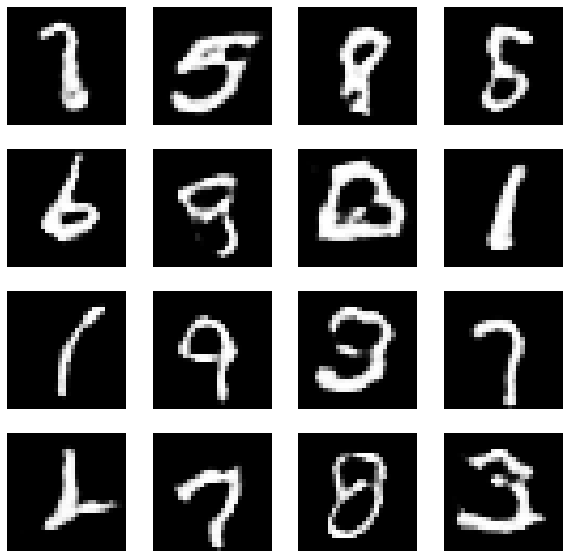

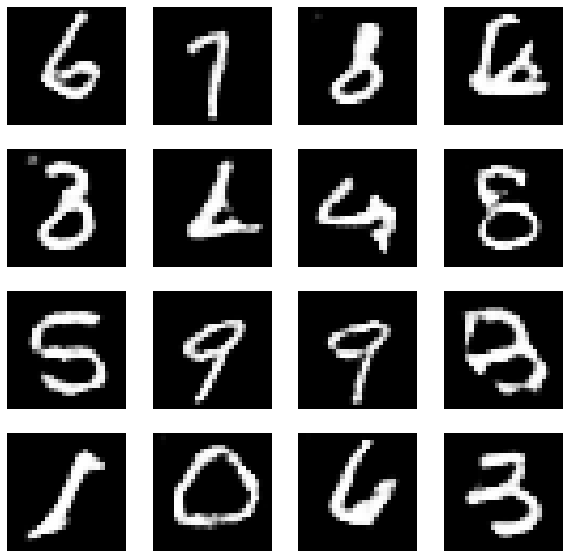

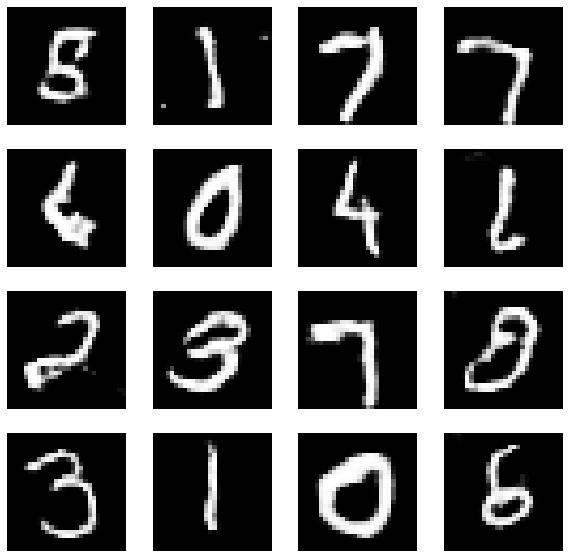

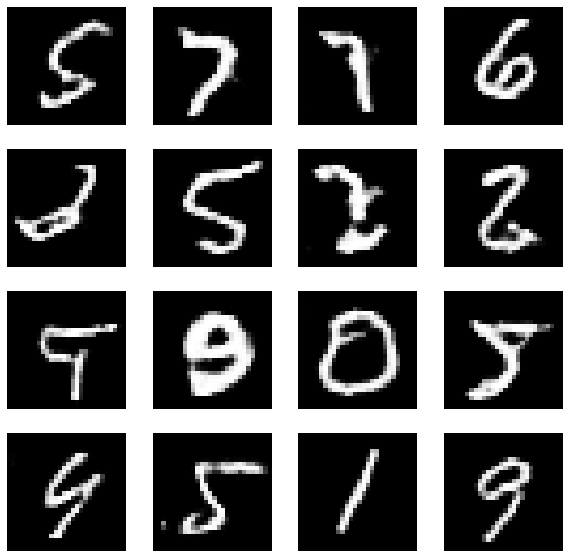

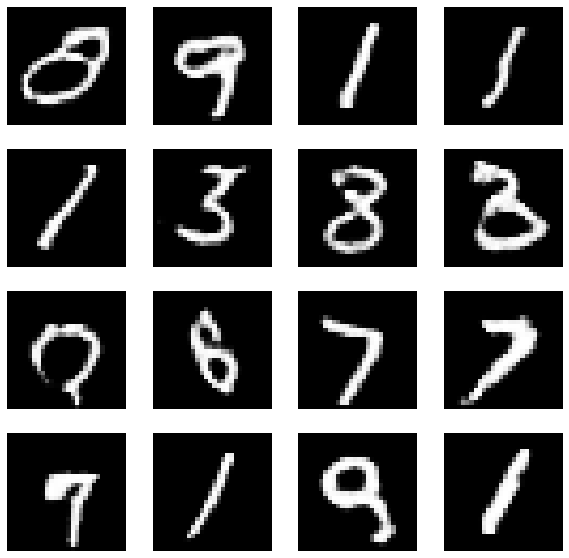

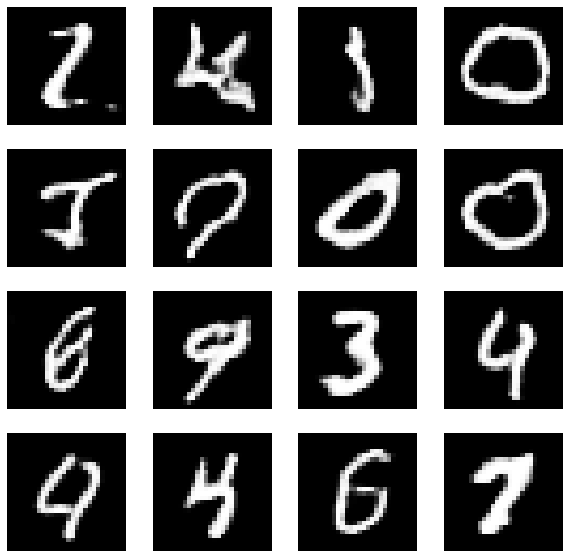

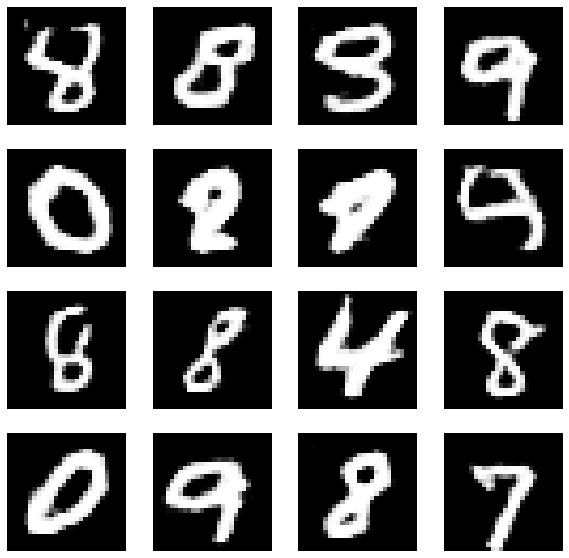

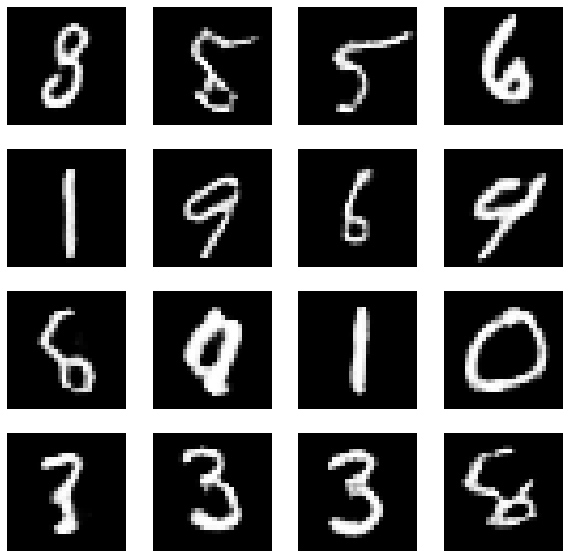

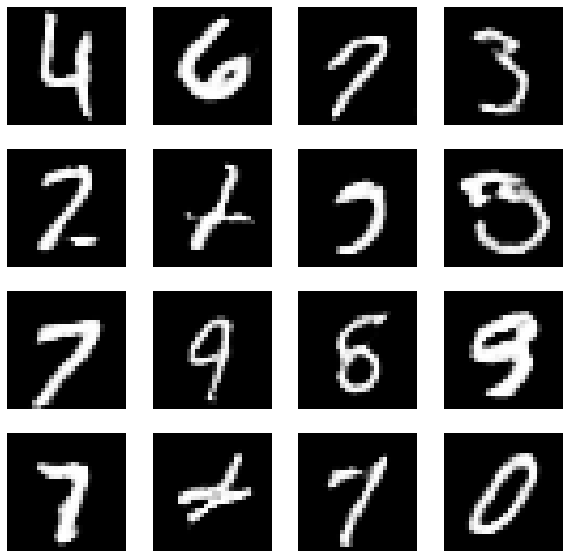

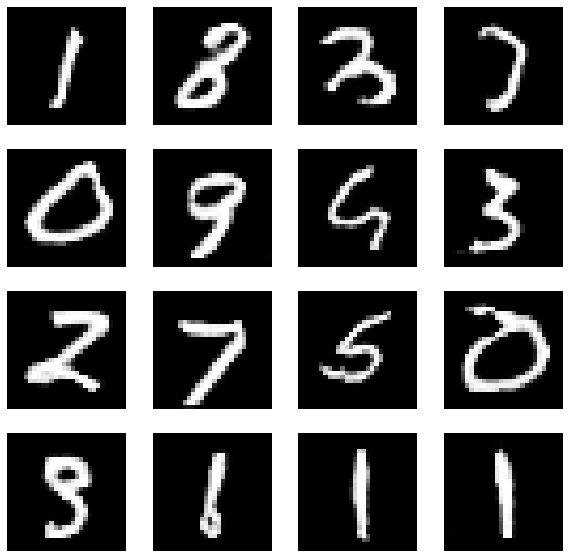

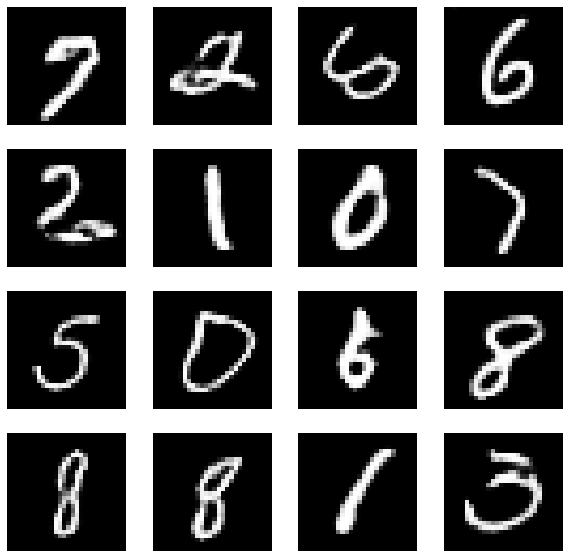

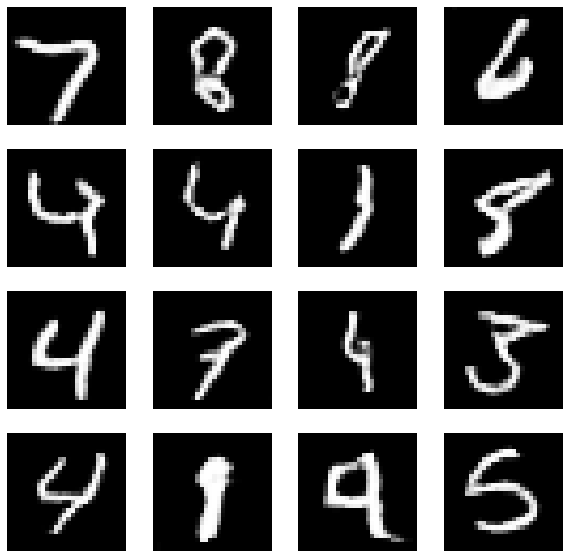

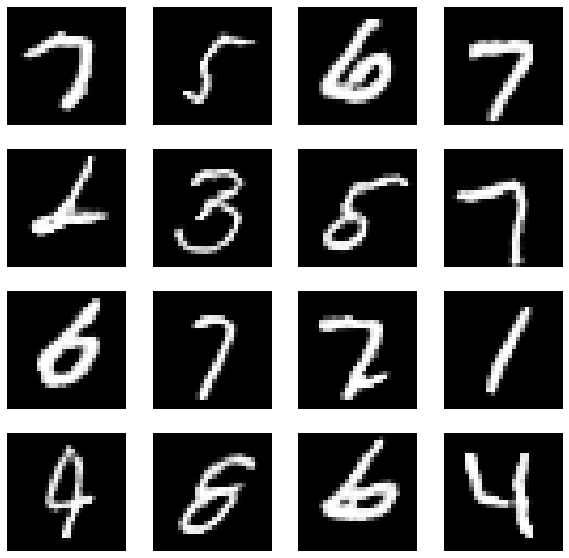

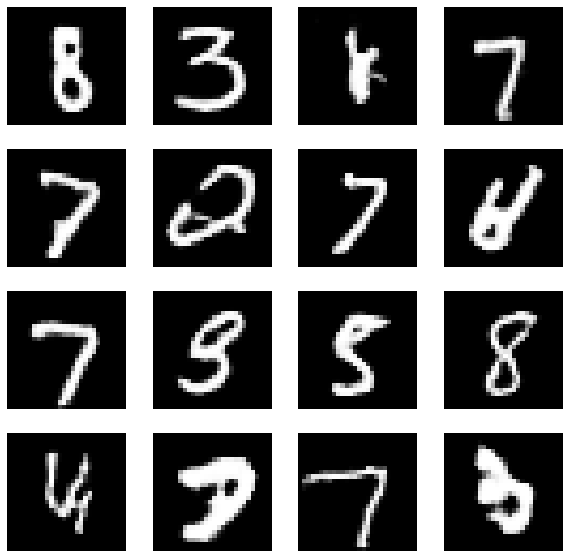

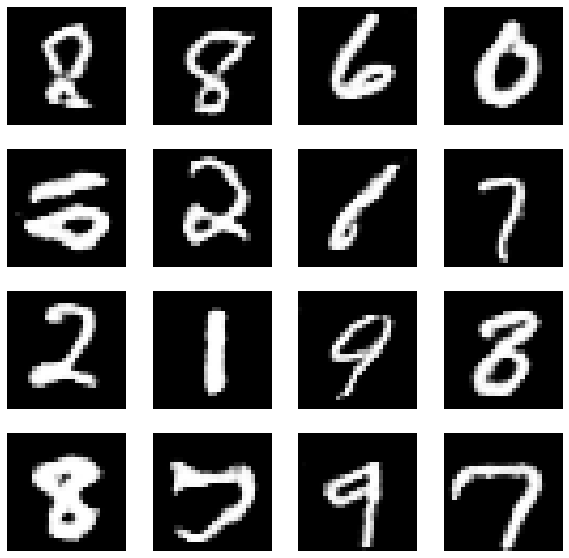

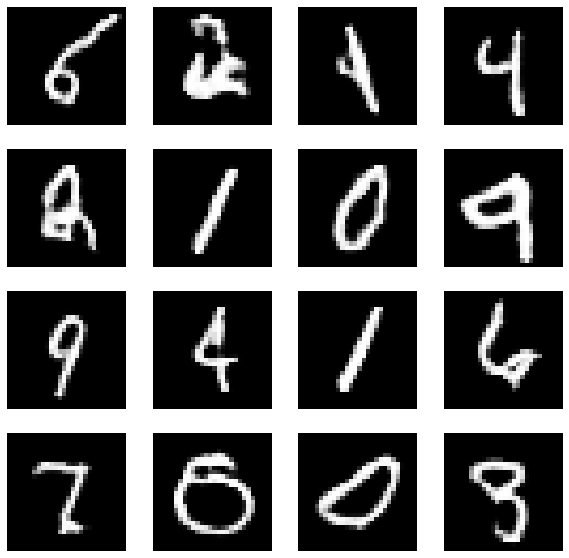

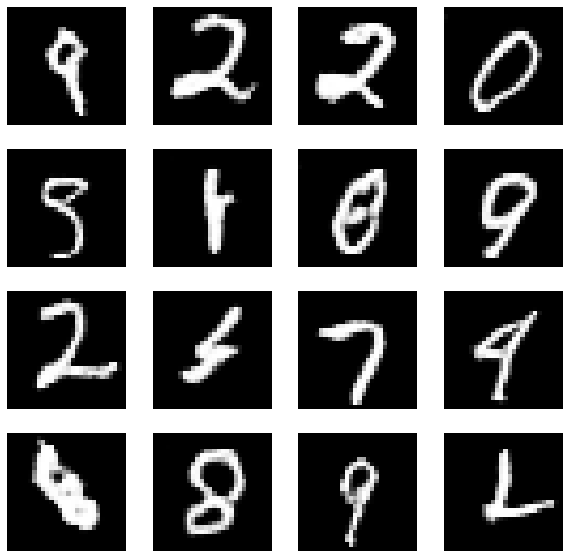

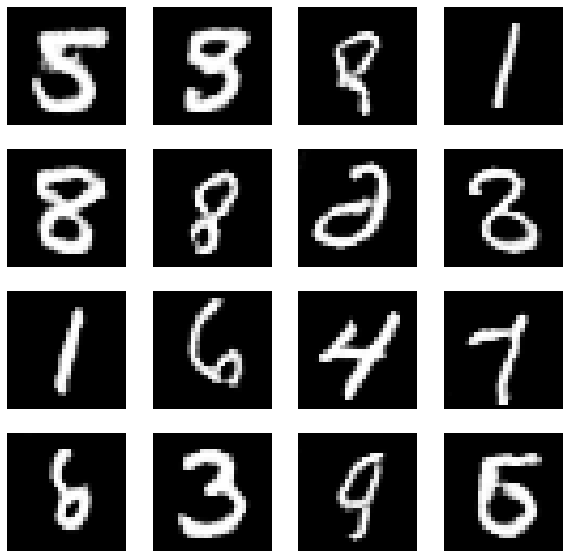

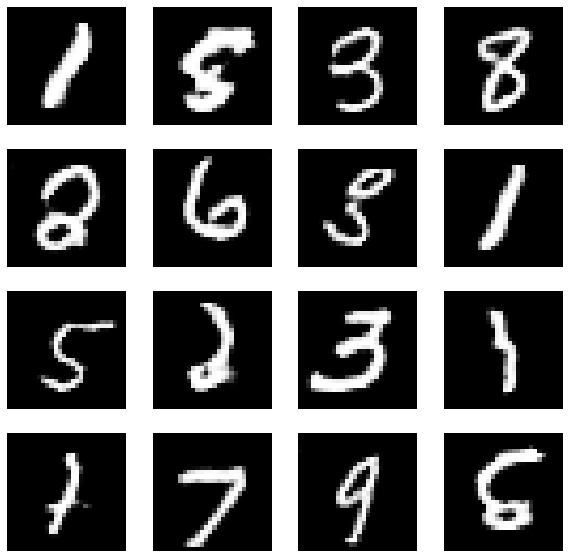

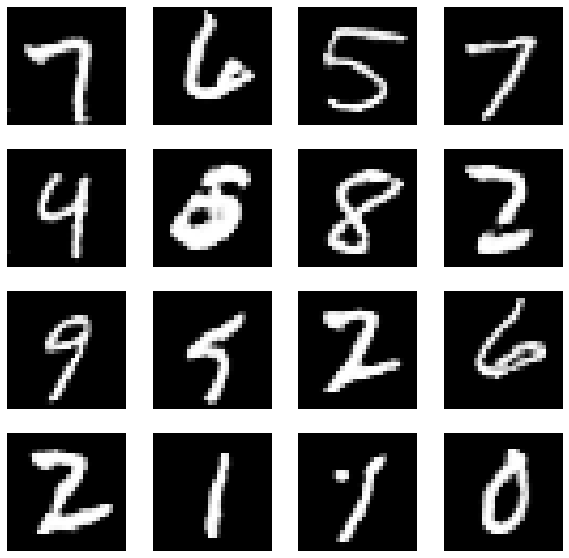

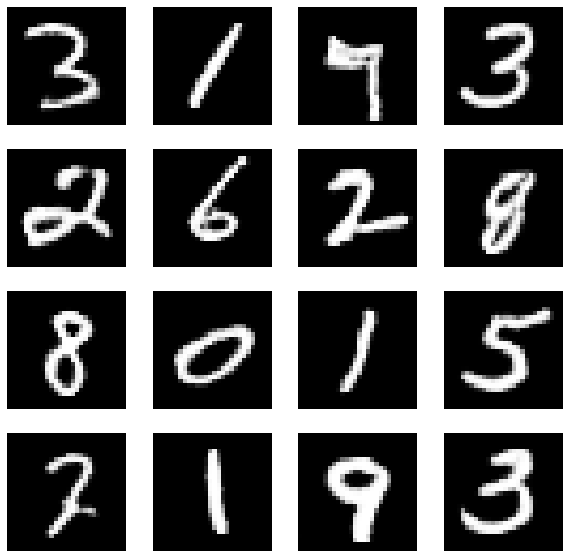

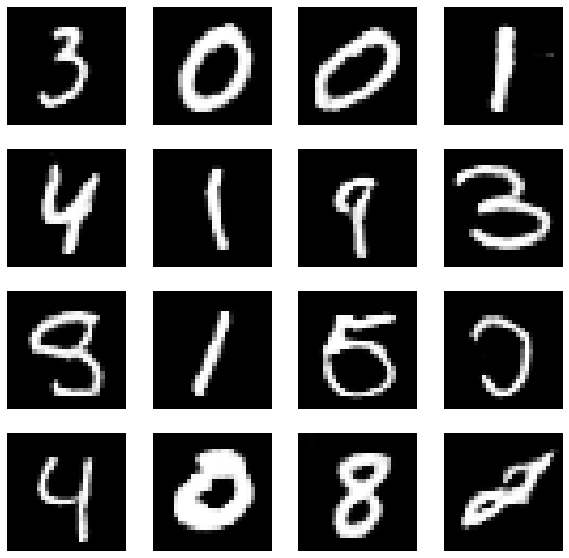

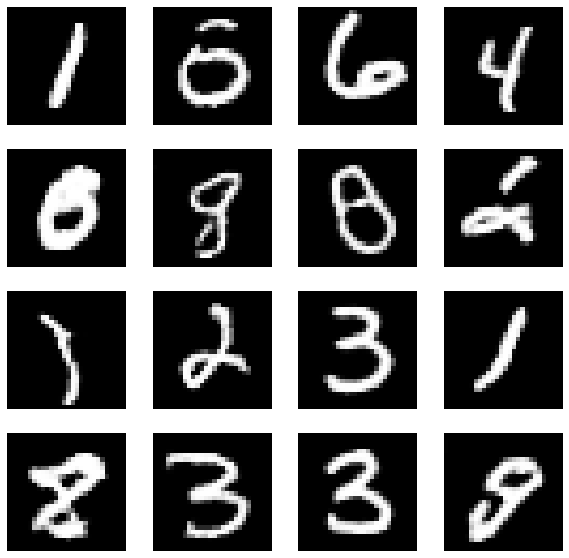

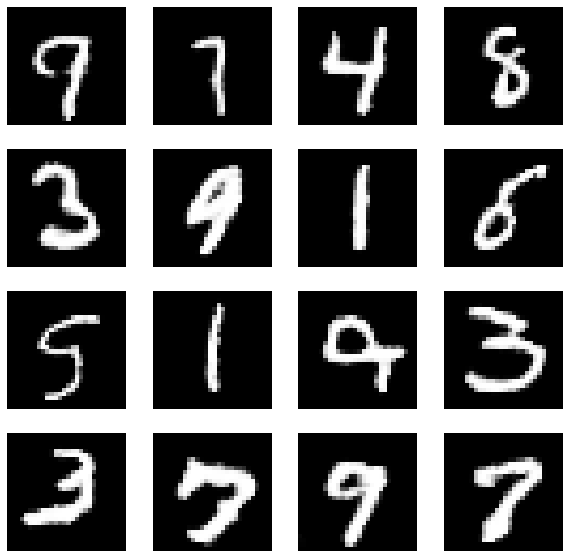

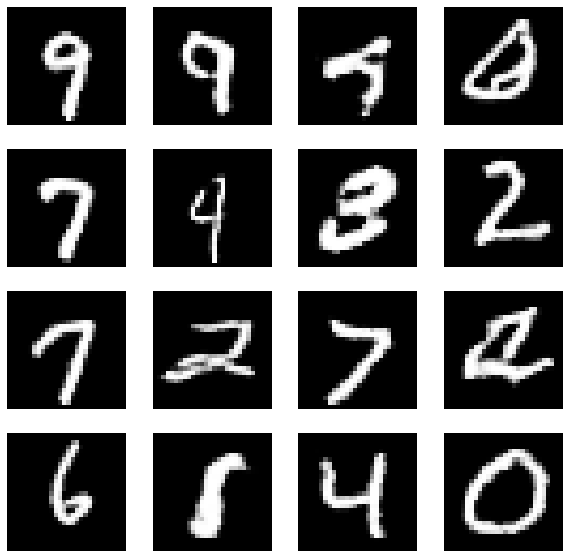

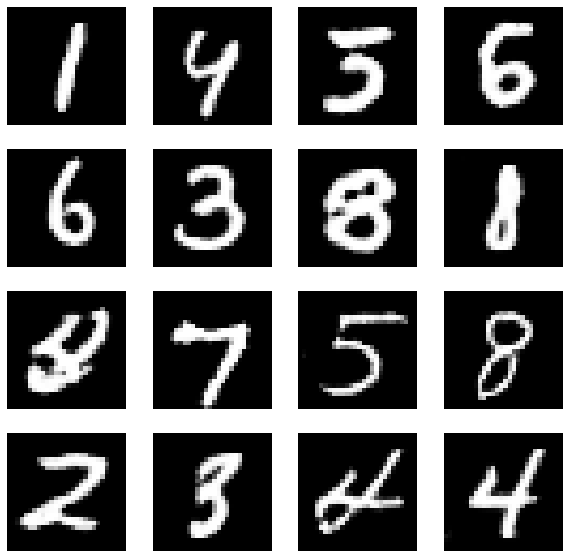

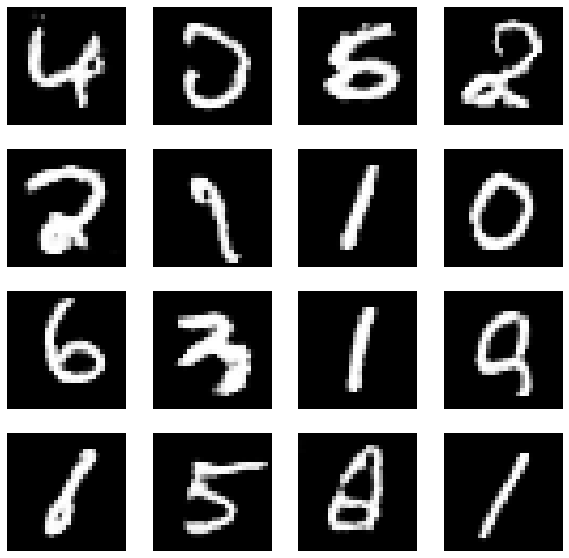

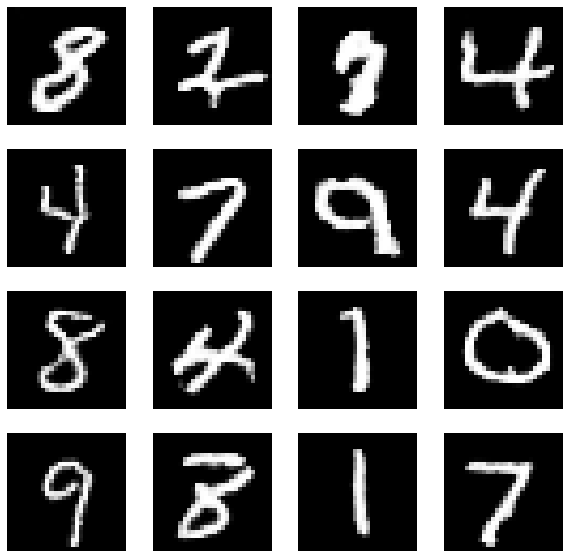

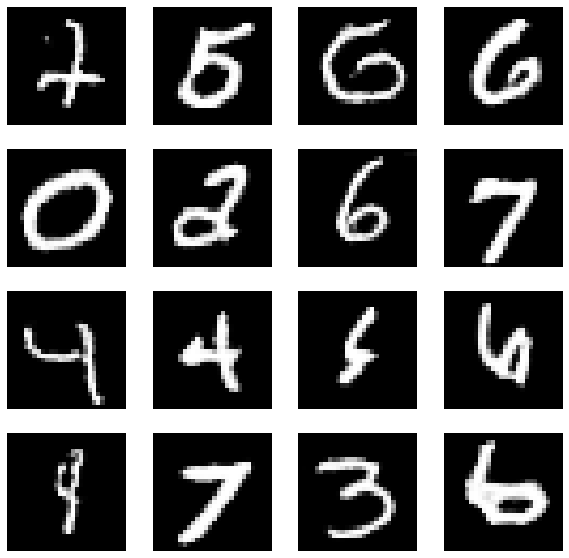

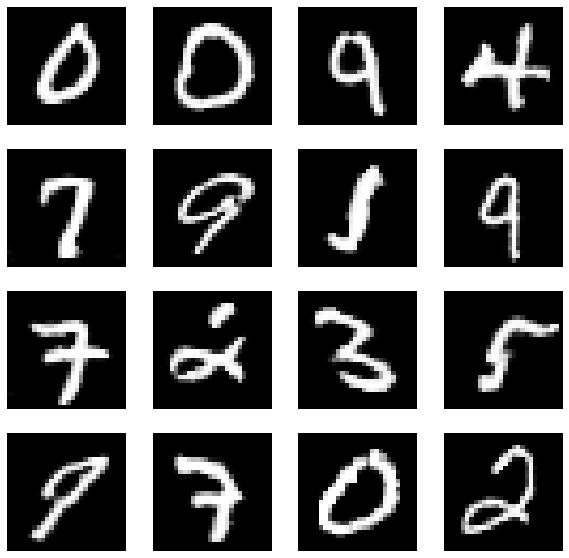

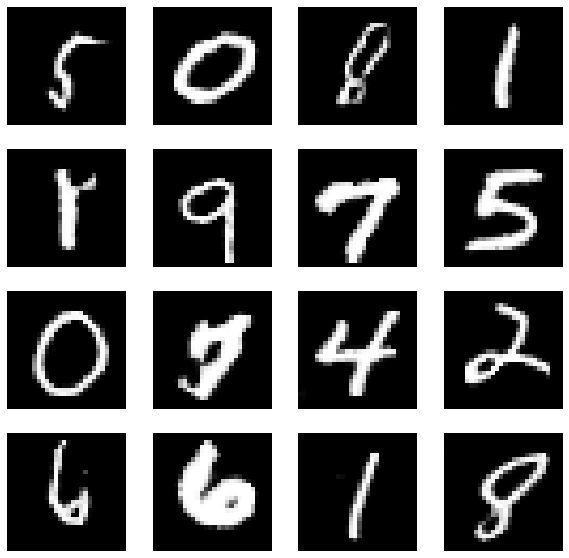

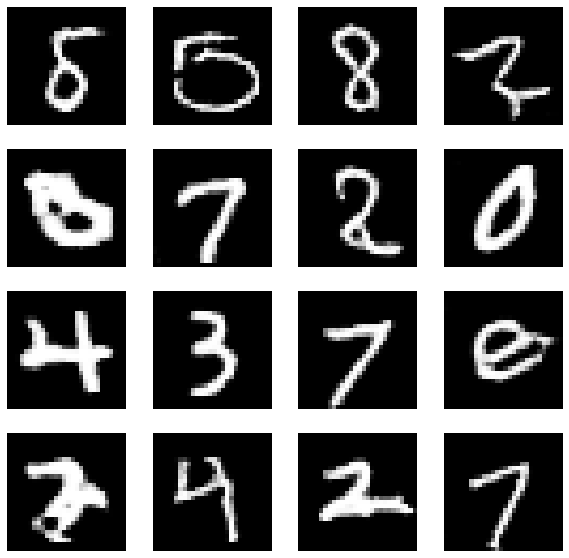

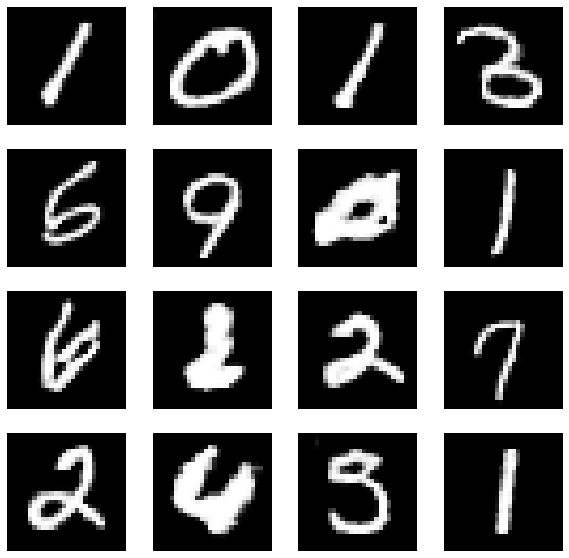

In [ ]:

if __name__ == '__main__':
  #!rm -rf runs
  gloss,dloss = train()

In [ ]:
num_itr = []
for i in range (len(gloss[0])):
  num_itr.append(i)
len(gloss[0])
len(dloss[0])

469

In [ ]:
import matplotlib.pyplot as plt
def model_plot(x,y,title,ep):

  plt.plot(x, y)
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.title(title+str(ep))
  
  # function to show the plot
  plt.show()

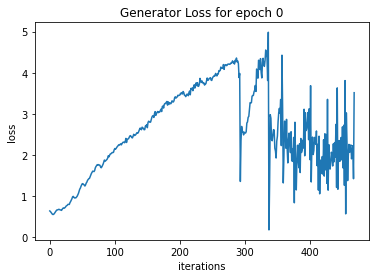

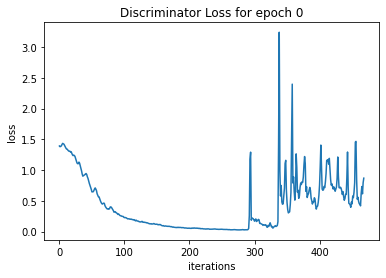

**************************************************


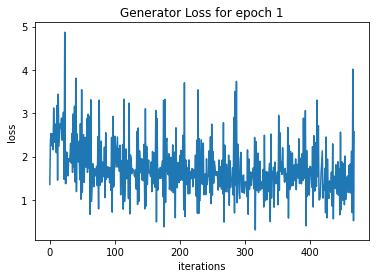

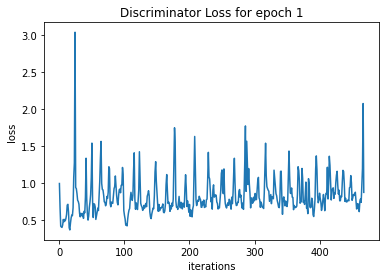

**************************************************


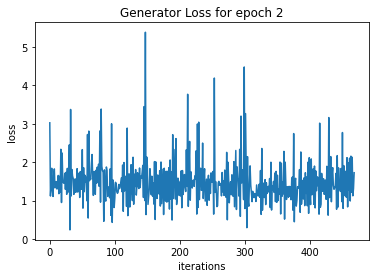

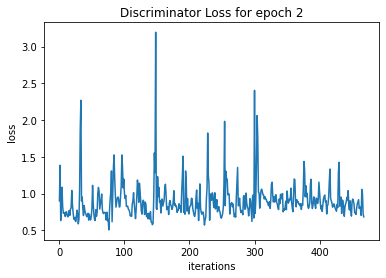

**************************************************


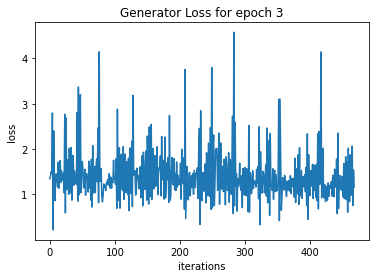

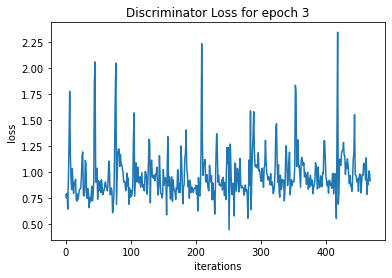

**************************************************


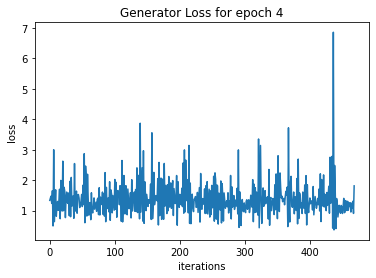

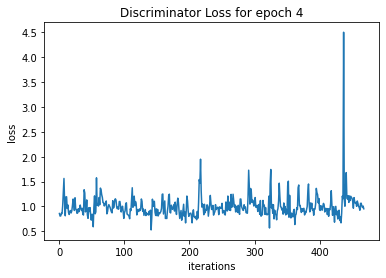

**************************************************


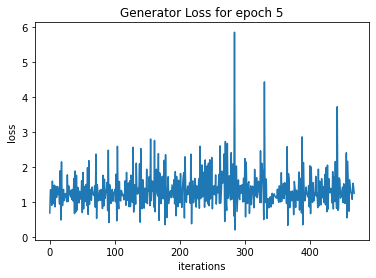

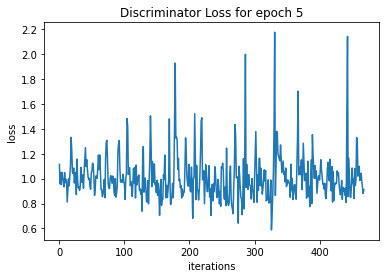

**************************************************


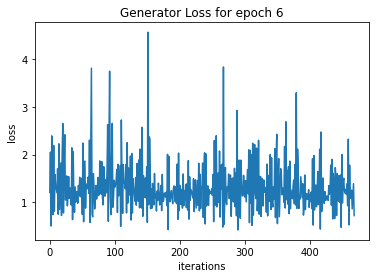

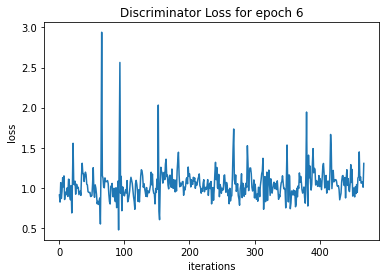

**************************************************


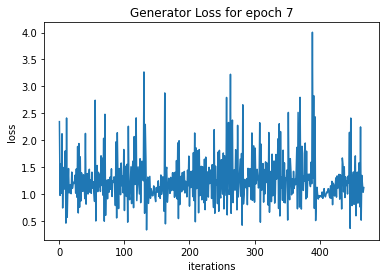

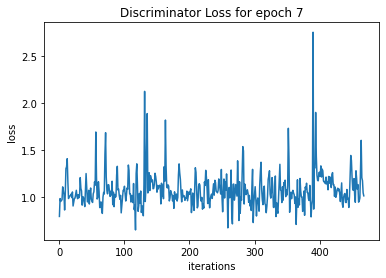

**************************************************


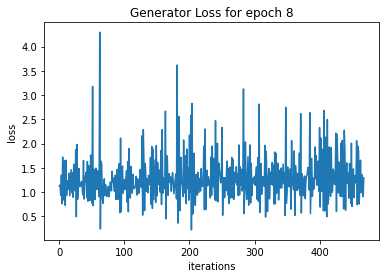

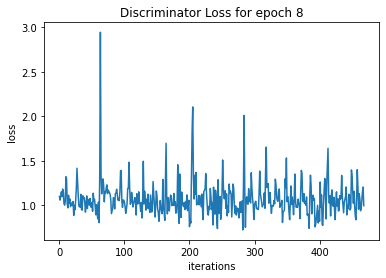

**************************************************


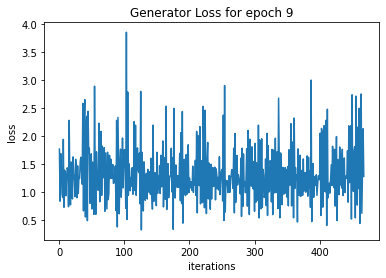

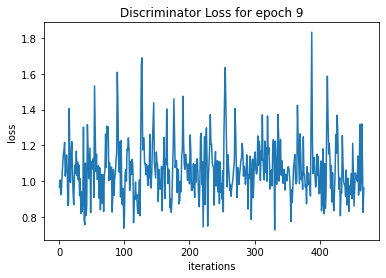

**************************************************


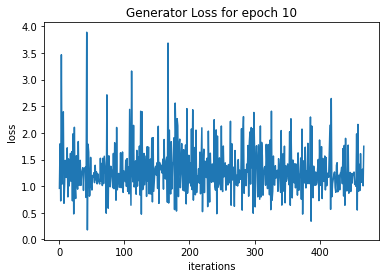

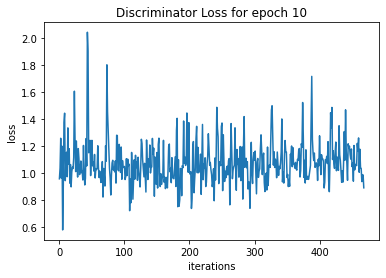

**************************************************


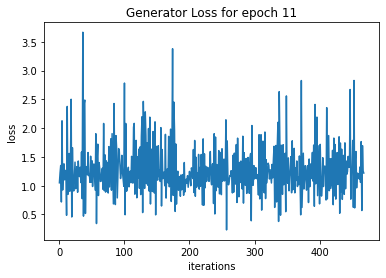

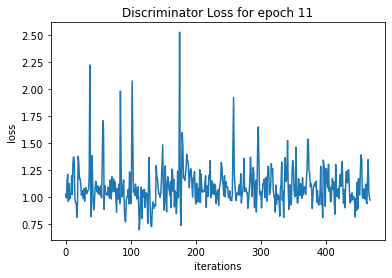

**************************************************


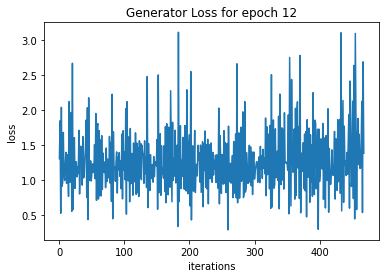

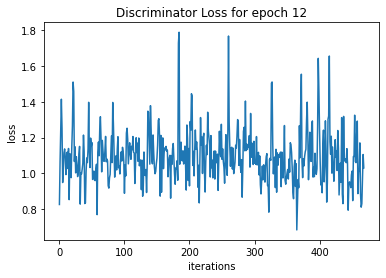

**************************************************


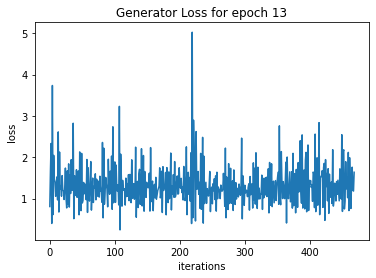

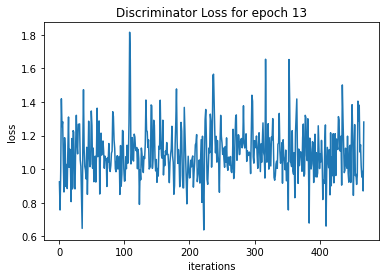

**************************************************


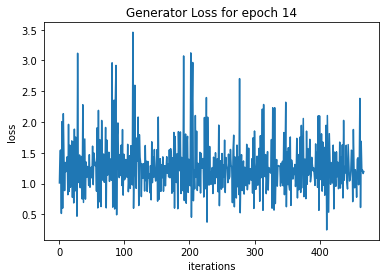

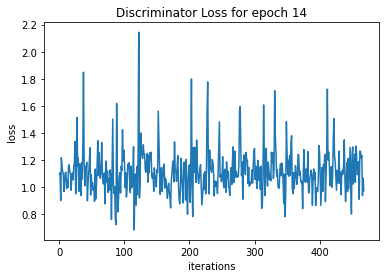

**************************************************


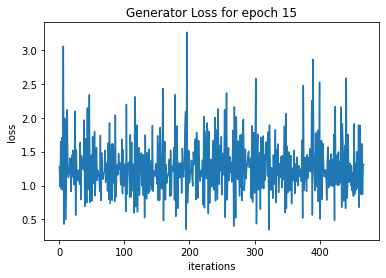

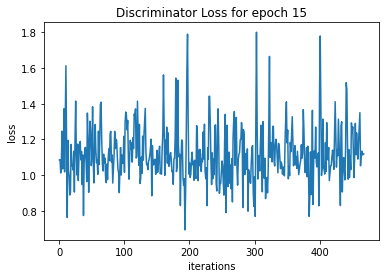

**************************************************


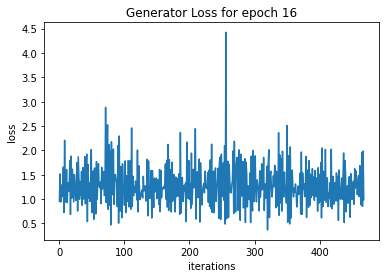

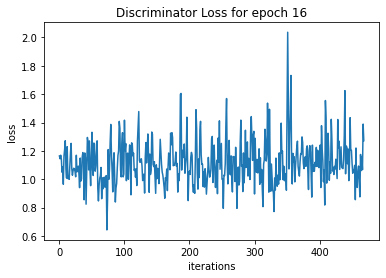

**************************************************


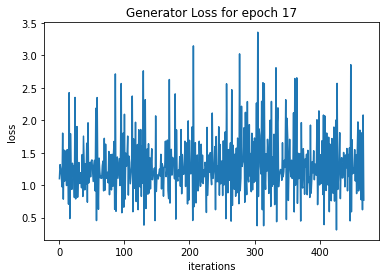

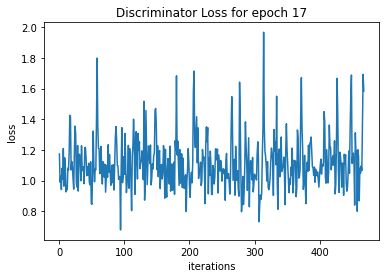

**************************************************


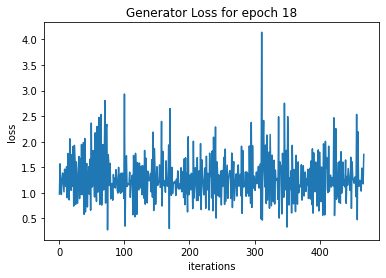

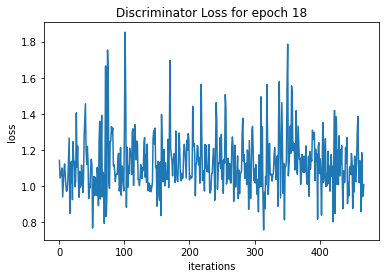

**************************************************


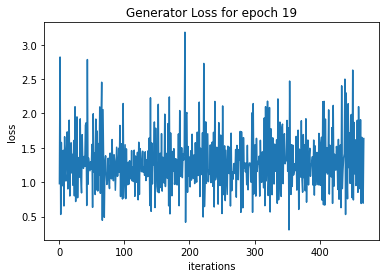

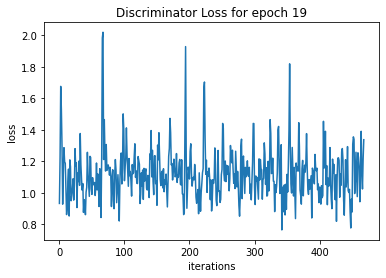

**************************************************


In [ ]:
for i in range(NUM_EPOCHS):
  
  model_plot(num_itr,gloss[i],"Generator Loss for epoch ",i)
  model_plot(num_itr,dloss[i],"Discriminator Loss for epoch ",i)
  print("**************************************************")

In [ ]:
g1 = gloss[0]+gloss[1]+gloss[2]+gloss[3]+gloss[4]+gloss[5]+gloss[6]+gloss[7]+gloss[8]+gloss[9]+gloss[10]+gloss[11]+gloss[12]+gloss[13]+gloss[14]+gloss[15]+gloss[16]+gloss[17]+gloss[18]+gloss[19]
len(g1)

9380

In [ ]:
d1 = dloss[0]+dloss[1]+dloss[2]+dloss[3]+dloss[4]+dloss[5]+dloss[6]+dloss[7]+dloss[8]+dloss[9]+dloss[10]+dloss[11]+dloss[12]+dloss[13]+dloss[14]+dloss[15]+dloss[16]+dloss[17]+dloss[18]+dloss[19]
len(d1)
tot_itr=[]
for i in range(len(d1)):
  tot_itr.append(i)

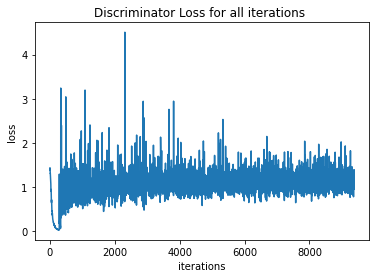

In [ ]:
model_plot(tot_itr,d1,"Discriminator Loss for all iterations ",'')

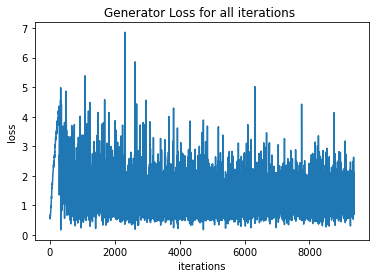

In [ ]:
model_plot(tot_itr,g1,"Generator Loss for all iterations ",'')